In [1]:
# Modelo 

import numpy as np
import pickle

# Função para calcular a razão de Poisson com base nas velocidades S e densidade
def calculate_poisson_ratios(vs, densities):
    vp = vs * 1.732
    poisson_ratios = 0.5 * (1 - (vs ** 2 / vp ** 2))
    return poisson_ratios

# Função para gerar um modelo sísmico completo com variação aleatória em cada receptor e gerar dados sísmicos sintéticos
def create_complete_seismic_model(num_receptors=10, num_shots=5, receptor_spacing=1, shot_spacing=2, num_layers=3):
    # Inicializar arrays para armazenar as variações de cada parâmetro para cada receptor
    depths = np.zeros((num_layers, num_receptors))
    vs = np.zeros((num_layers, num_receptors))
    densities = np.zeros((num_layers, num_receptors))
    poisson_ratios = np.zeros((num_layers, num_receptors))
    
    # Definir intervalos de variação para cada camada
    depth_ranges = [(0.1, 0.4), (0.6, 1.0), (0.60, 1.5)]
    vs_ranges = [(40, 140), (80, 160), (100, 240)]
    density_ranges = [(1200, 1500), (2800, 2800), (1300, 1600.1)]  # Pequena variação para 1600 fixo
    
    # Gerar variações aleatórias para cada camada e receptor
    for i in range(num_layers):
        for j in range(num_receptors):
            depths[i, j] = np.random.uniform(*depth_ranges[i])
            vs[i, j] = np.random.uniform(*vs_ranges[i])
            densities[i, j] = np.random.uniform(*density_ranges[i])
            # Calcular a razão de Poisson individualmente para cada ponto
            poisson_ratios[i, j] = calculate_poisson_ratios(np.array([vs[i, j]]), np.array([densities[i, j]]))[0]

    # Organizar receptores e tiros
    receptors = np.arange(0, num_receptors * receptor_spacing, receptor_spacing)
    shots = np.linspace(-num_shots * shot_spacing, num_receptors * receptor_spacing + num_shots * shot_spacing, num_shots)

    # Gerar dado sísmico sintético com base no modelo
    sample_rate = 0.004
    num_samples = 1001
    time = np.arange(num_samples) * sample_rate
    data = np.zeros((num_receptors, num_samples))
    
    for i in range(num_receptors):
        frequency = np.random.uniform(5, 50)
        data[i, :] = np.sin(2 * np.pi * frequency * time) + 0.6 * np.random.randn(num_samples)
    
    # Salvar modelo e dados
    model = {
        'velocities': vs,
        'depths': depths,
        'densities': densities,
        'poisson_ratios': poisson_ratios,
        'receptors': receptors,
        'shots': shots,
        'num_layers': num_layers,
        'num_receptors': num_receptors,
        'num_shots': num_shots,
        'synthetic_data': data  # Salvando o dado sísmico gerado
    }

    with open('seismic_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    return model

# Função principal
def main():
    num_receptors = 10      # Modificar conforme necessário
    num_shots = 2          # Modificar conforme necessário
    receptor_spacing = 4     # Modificar o espaçamento entre receptores conforme necessário
    shot_spacing = 2         # Modificar o espaçamento entre tiros conforme necessário
    create_complete_seismic_model(num_receptors=num_receptors, num_shots=num_shots, 
                                  receptor_spacing=receptor_spacing, shot_spacing=shot_spacing)

if __name__ == "__main__":
    main()


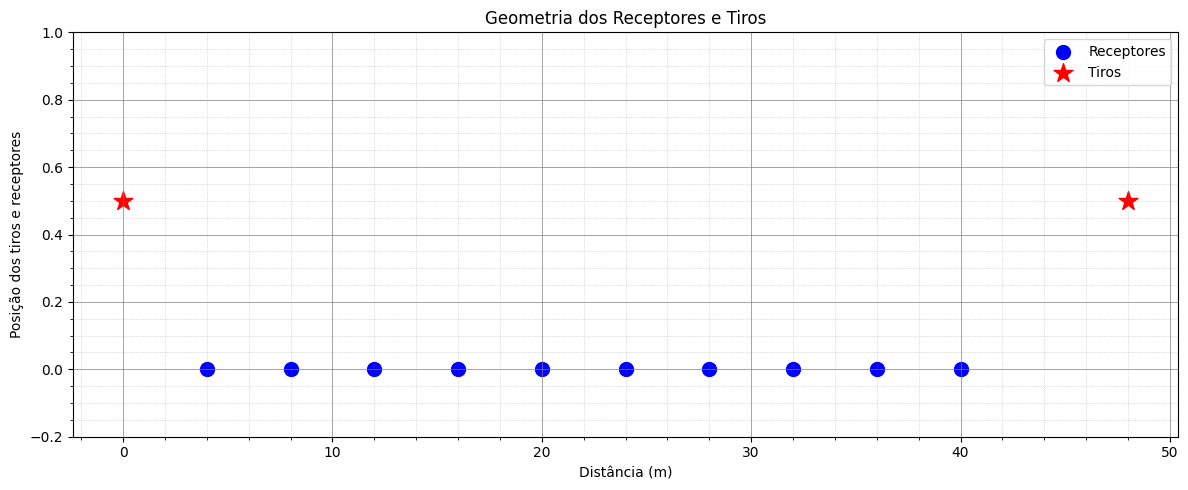

In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

def plot_receptor_shot_geometry():
    # Carregar o modelo sísmico a partir do arquivo
    with open('seismic_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    # Extrair dados do modelo
    receptors = model['receptors'].astype(float)  # Converter para float para evitar problemas de casting
    shots = model['shots'].astype(float)  # Converter para float para evitar problemas de casting

    # Organizar os eixos para valores apenas positivos
    # Shiftando todos os valores de tiro e receptores para serem positivos
    min_value = min(np.min(receptors), np.min(shots))
    if min_value < 0:
        shift = np.abs(min_value)
        receptors += shift
        shots += shift
    
    # Adicionar um deslocamento para os tiros, evitando sobreposição visual com os receptores
    shot_offset = 0.5  # Valor para deslocar os tiros (ajustável)
    shots_position = np.full_like(shots, shot_offset)  # Deslocamento para os tiros
    receptors_position = np.zeros_like(receptors)  # Manter os receptores na linha zero
    
    fig, ax = plt.subplots(figsize=(12, 5))  # Aumentar o tamanho para uma melhor visualização
    
    # Plotando os receptores
    ax.scatter(receptors, receptors_position, color='blue', label='Receptores', s=100)
    
    # Marcando os tiros (com deslocamento para melhor visualização)
    ax.scatter(shots, shots_position, color='red', marker='*', s=200, label='Tiros')

    # Configurações do gráfico
    ax.set_xlabel('Distância (m)')
    ax.set_ylabel('Posição dos tiros e receptores')
    ax.set_title('Geometria dos Receptores e Tiros')

    # Limites do eixo y para que os tiros e receptores não se sobreponham
    ax.set_ylim(-0.2, shot_offset + 0.5)

    ax.legend(loc='upper right')
    #ax.grid(True)
    # Ajustar layout e salvar o gráfico
    plt.tight_layout()
    plt.minorticks_on()  
    plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)    

    plt.savefig('receptor_shot_geometry_final.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    plot_receptor_shot_geometry()


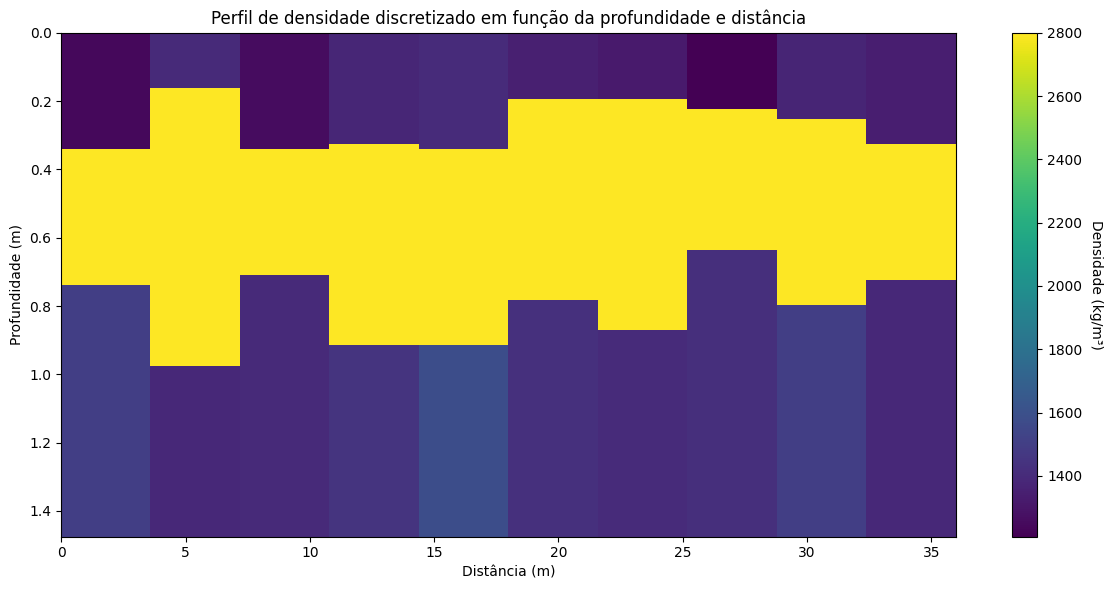

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Carregar o modelo sísmico gerado pelo script de criação flexível
with open('seismic_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Extrair parâmetros do modelo
depths = model['depths']
densities = model['densities']
velocities = model['velocities']
poisson_ratios = model['poisson_ratios']
receptors = model['receptors']

# Garantir que depths e densities são bidimensionais
num_layers = depths.shape[0]
num_receptors = len(receptors)

# Ajustar depths e densities para corresponder ao número de receptores
if depths.shape[1] < num_receptors:
    depths = np.hstack([depths, np.tile(depths[:, -1:], (1, num_receptors - depths.shape[1]))])
if densities.shape[1] < num_receptors:
    densities = np.hstack([densities, np.tile(densities[:, -1:], (1, num_receptors - densities.shape[1]))])

# Parâmetros da grade de discretização
num_depth_points = 100  # Número de pontos na profundidade
depth_grid = np.linspace(0, depths.max(), num_depth_points)

# Inicializar o perfil de densidade como uma grade 2D
density_grid = np.zeros((num_depth_points, num_receptors))

# Preencher a grade de densidade considerando a profundidade variável em cada receptor
for j, receptor_position in enumerate(receptors):
    for i in range(num_layers):
        depth_layer_j = depths[i, j]
        depth_idx = np.searchsorted(depth_grid, depth_layer_j)
        if i == 0:
            density_grid[:depth_idx, j] = densities[i, j]
        else:
            prev_depth_idx = np.searchsorted(depth_grid, depths[i - 1, j])
            density_grid[prev_depth_idx:depth_idx, j] = densities[i, j]

# Preencher a última camada até o final da profundidade
for j in range(num_receptors):
    last_depth_idx = np.searchsorted(depth_grid, depths[-1, j])
    density_grid[last_depth_idx:, j] = densities[-1, j]

# Salvar o modelo discretizado com todos os parâmetros necessários
discretized_model = {
    'density_grid': density_grid,
    'depth_grid': depth_grid,
    'receptor_positions': receptors,
    'velocities': velocities,
    'depths': depths,
    'densities': densities,
    'poisson_ratios': poisson_ratios
}
with open('discretized_model.pkl', 'wb') as f:
    pickle.dump(discretized_model, f)

# Plotar o perfil de densidade ajustado
fig, ax = plt.subplots(figsize=(12, 6))
cmap = plt.get_cmap("viridis")
norm = mcolors.Normalize(vmin=density_grid.min(), vmax=density_grid.max())
extent = [receptors.min(), receptors.max(), depth_grid.max(), 0]
cax = ax.imshow(density_grid, extent=extent, origin='upper', cmap=cmap, aspect='auto', norm=norm)

# Adicionar barra de cores
cbar = fig.colorbar(cax)
cbar.set_label('Densidade (kg/m³)', rotation=270, labelpad=15)

# Configurações do gráfico
ax.set_xlabel('Distância (m)')
ax.set_ylabel('Profundidade (m)')
ax.set_title('Perfil de densidade discretizado em função da profundidade e distância')

# Ajustar layout e salvar o gráfico
plt.tight_layout()
plt.savefig('perfil_densidade_discretizado.png', dpi=300)
plt.show()


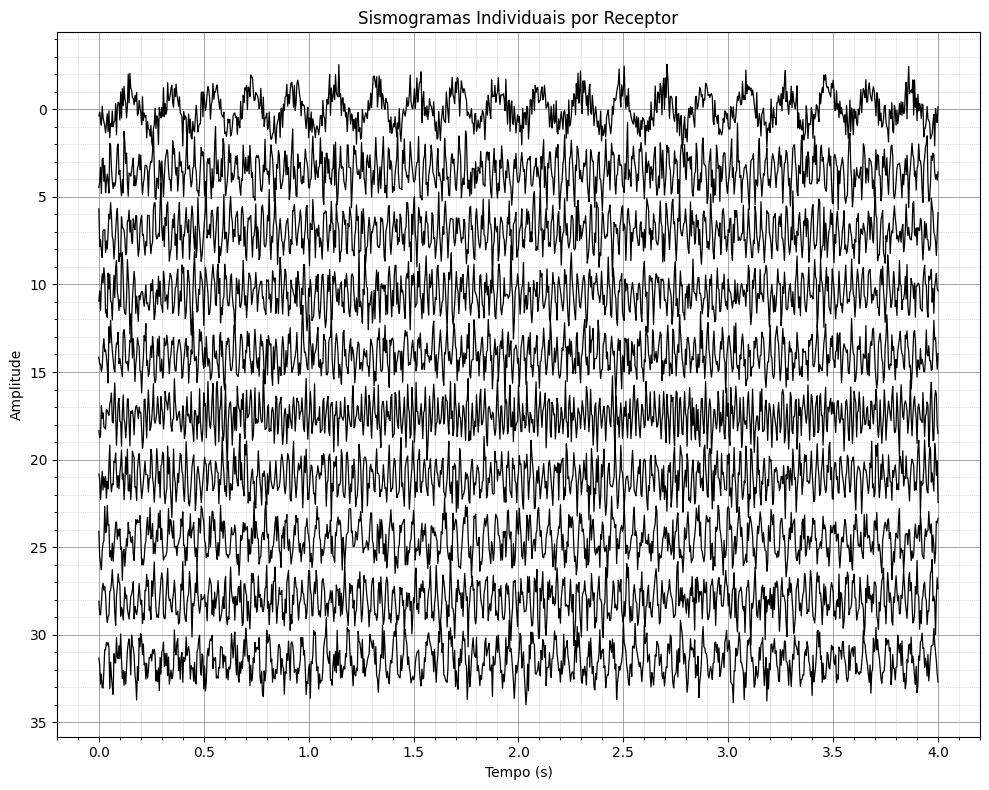

In [4]:
# Gerar sismograma

import matplotlib.pyplot as plt
import pickle
import numpy as np

def plot_seismic_traces():
    # Carregar o modelo sísmico e os dados a partir do arquivo
    with open('seismic_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    data = model['synthetic_data']  # Dados sísmicos gerados
    num_receptors, num_samples = data.shape
    
    # Criar o vetor de tempo com base na taxa de amostragem
    sample_rate = 0.004
    time = np.arange(num_samples) * sample_rate
    
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plotar cada traço sísmico como um sismograma separado
    for i in range(num_receptors):
        ax.plot(time, data[i] + i * 3.5, color='black', linewidth=0.9)
        
    # Configurações do gráfico
    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Sismogramas Individuais por Receptor')
    ax.invert_yaxis()  # Inverte o eixo Y para que o tempo aumente para baixo, como em sismogramas convencionais
    #ax.grid(True)
    
    plt.tight_layout()
    plt.minorticks_on()  
    plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)    

    plt.savefig('seismic_traces.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    plot_seismic_traces()


In [5]:
# Calcular a curva de dispersão

import numpy as np
import pickle
from scipy.interpolate import interp1d

# Função para garantir que os arrays sejam interpolados para um comprimento uniforme
def standardize_length(arr, target_length):
    if arr.size == target_length:
        return arr  # Retorna o array se já tiver o comprimento alvo
    x_old = np.linspace(0, 1, arr.size)
    x_new = np.linspace(0, 1, target_length)
    return interp1d(x_old, arr, kind='linear', fill_value="extrapolate")(x_new)

# Função para calcular a curva de dispersão
def calculate_dispersion_curve(velocities, depths, densities, poisson_ratios, target_length=50):
    velocities = standardize_length(velocities.flatten(), target_length)
    depths = standardize_length(depths.flatten(), target_length)
    densities = standardize_length(densities.flatten(), target_length)
    poisson_ratios = standardize_length(poisson_ratios.flatten(), target_length)
    
    frequencies = np.linspace(10.0, 100.0, target_length)
    p_wave_velocities = velocities * np.sqrt((2 * (1 - poisson_ratios)) / (1 - 2 * poisson_ratios))
    
    dispersion_curve = np.zeros_like(frequencies)
    
    for i in range(target_length):
        layer_dispersion = (p_wave_velocities[i] / (1 + frequencies)) * (depths[i] ** 2 / densities[i])
        #noise = np.random.normal(0, 0.007 * np.abs(layer_dispersion))
        dispersion_curve += layer_dispersion #  + noise

    return frequencies, dispersion_curve

# Função para calcular a média de várias curvas de dispersão
def calculate_average_dispersion_curve(dispersion_curves):
    dispersion_curves = np.array(dispersion_curves)
    return np.mean(dispersion_curves, axis=0)

# Calcular todas as curvas de dispersão e salvar
def calculate_and_save_dispersion_curves():
    with open('seismic_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    velocities = model['velocities']
    depths = model['depths']
    densities = model['densities']
    poisson_ratios = model['poisson_ratios']
    
    dispersion_curves = []
    target_length = 50

    # Gerar 10 curvas de dispersão diferentes
    for _ in range(10):
        _, dispersion_curve = calculate_dispersion_curve(velocities, depths, densities, poisson_ratios, target_length)
        dispersion_curves.append(dispersion_curve)
    
    # Calcular a média das curvas de dispersão
    average_dispersion_curve = calculate_average_dispersion_curve(dispersion_curves)
    
    # Salvar todas as curvas de dispersão e a média
    with open('dispersion_curves.pkl', 'wb') as f:
        pickle.dump({'curves': dispersion_curves, 'average_curve': average_dispersion_curve}, f)

if __name__ == "__main__":
    calculate_and_save_dispersion_curves()


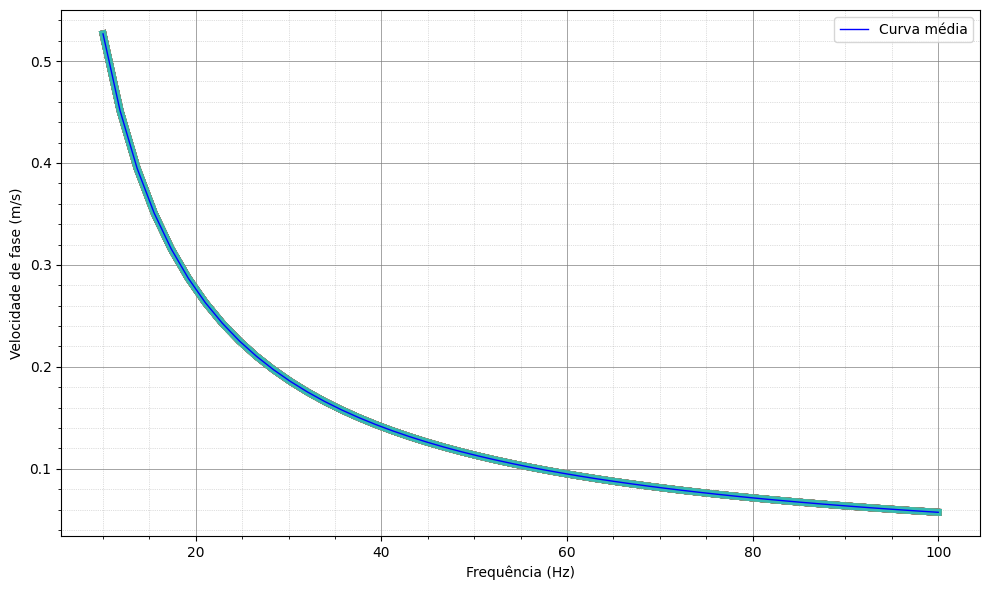

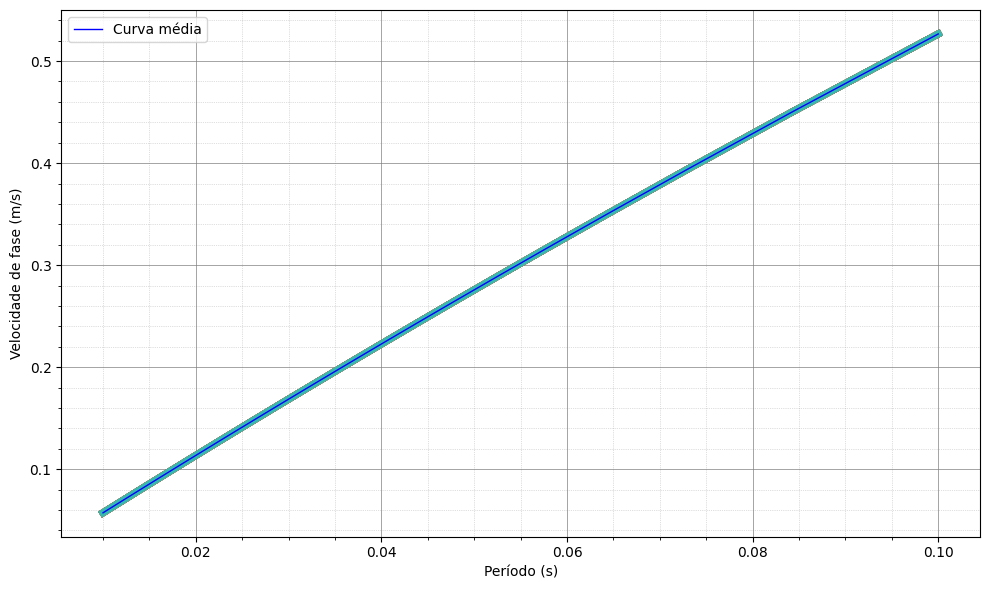

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Função para carregar e plotar as curvas de dispersão
def plot_dispersion_curves_from_saved():
    # Carregar as curvas de dispersão pré-calculadas
    with open('dispersion_curves.pkl', 'rb') as f:
        data = pickle.load(f)
    
    dispersion_curves = data['curves']
    average_dispersion_curve = data['average_curve']

    # Definir os eixos de frequência
    target_length = 50
    frequencies = np.linspace(10.0, 100.0, target_length)

    # Plotar todas as curvas de dispersão
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for curve in dispersion_curves:
        ax.plot(frequencies, curve, alpha=0.8, linewidth=5)
    
    # Plotar a curva média
    ax.plot(frequencies, average_dispersion_curve, color='blue', linewidth=1, label='Curva média')
    
    ax.set_xlabel('Frequência (Hz)')
    ax.set_ylabel('Velocidade de fase (m/s)')
    plt.tight_layout()
    ax.legend()
    ax.minorticks_on()
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
    plt.savefig('curvas_dispersao_frequencia.png', dpi=300)
    plt.show()

    # Plotar as curvas de dispersão em função do período (1/frequência)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for curve in dispersion_curves:
        ax.plot(1/frequencies, curve, alpha=0.8, linewidth=5)
    
    # Plotar a curva média
    ax.plot(1/frequencies, average_dispersion_curve, color='blue', linewidth=1, label='Curva média')
    
    ax.set_xlabel('Período (s)')
    ax.set_ylabel('Velocidade de fase (m/s)')
    plt.tight_layout()
    ax.legend()
    ax.minorticks_on()
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
    plt.savefig('curvas_dispersao_periodo.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    plot_dispersion_curves_from_saved()


Velocidades Vs estimadas foram salvas em 'vs_estimated.pkl'.


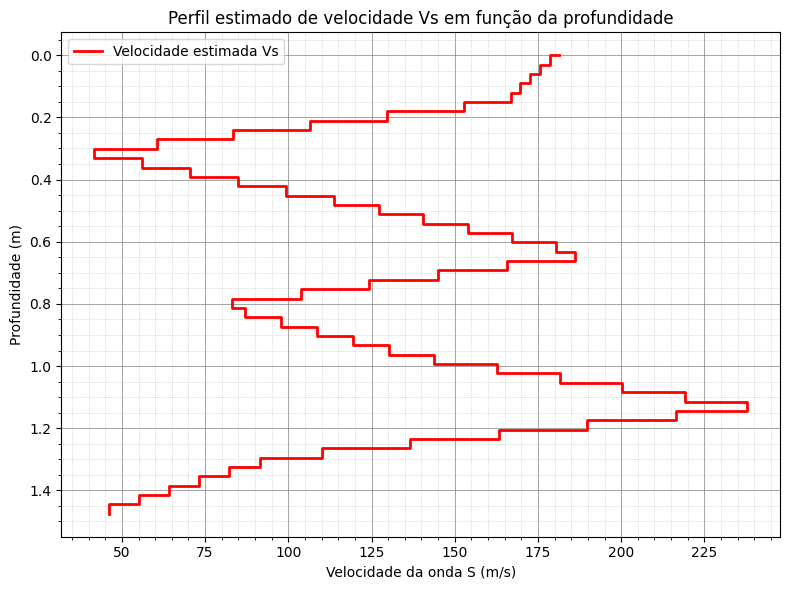

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.interpolate import interp1d

# Função para estimar o perfil de velocidade Vs com base nos dados sísmicos
def estimate_vs_from_seismic_data(synthetic_data, depths, target_length=50):
    # Estimando uma média do sinal sísmico para cada profundidade
    mean_signal = np.mean(synthetic_data, axis=1)
    
    # Garantir que os eixos "depths" e "mean_signal" tenham o mesmo comprimento
    if len(depths.flatten()) != len(mean_signal):
        depths = np.linspace(0, depths.max(), len(mean_signal))

    # Calcular os valores máximos e mínimos de velocidade com base no dado sísmico
    max_velocity = np.percentile(mean_signal, 95)  # Definir percentil 95 para evitar valores extremos
    min_velocity = np.percentile(mean_signal, 5)   # Definir percentil 5 para evitar valores muito baixos

    # Interpolar para ajustar a faixa de velocidades (mapeando os valores de sinal sísmico para velocidades)
    velocities = np.interp(mean_signal, (min_velocity, max_velocity), (40, 240))  # Intervalo de 40 a 240 m/s

    # Ajustar a profundidade para ter o mesmo número de pontos que a curva de velocidades
    target_depth_points = np.linspace(0, depths.max(), target_length)
    interp_func = interp1d(depths, velocities, kind='linear', fill_value="extrapolate")
    adjusted_velocities = interp_func(target_depth_points)
    
    return adjusted_velocities, target_depth_points

def plot_vs_depth():
    # Carregar o modelo sísmico e o dado gerado
    with open('seismic_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    synthetic_data = model['synthetic_data']  # Usando os dados sísmicos gerados
    depths = model['depths']

    # Estimando Vs com base nos dados sísmicos
    adjusted_velocities, target_depth_points = estimate_vs_from_seismic_data(synthetic_data, depths)

    # Salvar os resultados estimados para o Script 2
    save_vs_estimated(adjusted_velocities, target_depth_points)

    # Plotar o perfil de velocidade Vs em função da profundidade ajustada
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.step(adjusted_velocities, target_depth_points, where='post', color='red', linewidth=2, label='Velocidade estimada Vs')  

    # Configurações do gráfico
    ax.set_xlabel('Velocidade da onda S (m/s)')
    ax.set_ylabel('Profundidade (m)')
    ax.set_title('Perfil estimado de velocidade Vs em função da profundidade')
    ax.invert_yaxis()  # Inverte o eixo Y para que a profundidade aumente para baixo
    ax.grid(True)

    # Mostrar a legenda, se houver label
    ax.legend()

    # Exibir e salvar o gráfico
    plt.tight_layout()
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
    plt.savefig('vs_profundidade_estimado.png', dpi=300)
    plt.show()

# Função para salvar as velocidades estimadas para o Script 2
def save_vs_estimated(velocities, depths):
    vs_estimated_data = {
        'velocities': velocities,
        'depths': depths
    }
    with open('vs_estimated.pkl', 'wb') as f:
        pickle.dump(vs_estimated_data, f)
    print("Velocidades Vs estimadas foram salvas em 'vs_estimated.pkl'.")

if __name__ == "__main__":
    plot_vs_depth()


gen	nevals
0  	50    
1  	40    
2  	34    
3  	39    
4  	26    
5  	21    
6  	35    
7  	31    
8  	27    
9  	38    
10 	27    
11 	25    
12 	33    
13 	32    
14 	34    
15 	29    
16 	31    
17 	22    
18 	25    
19 	26    
20 	32    
21 	34    
22 	28    
23 	31    
24 	38    
25 	24    
26 	41    
27 	30    
28 	31    
29 	29    
30 	35    
31 	32    
32 	30    
33 	22    
34 	31    
35 	22    
36 	35    
37 	25    
38 	32    
39 	36    
40 	31    
41 	40    
42 	30    
43 	26    
44 	23    
45 	26    
46 	31    
47 	29    
48 	33    
49 	26    
50 	35    


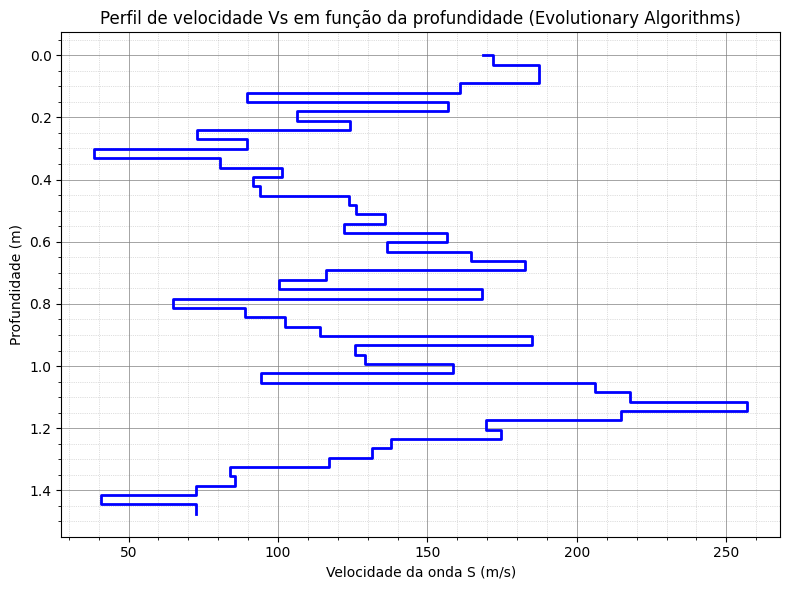

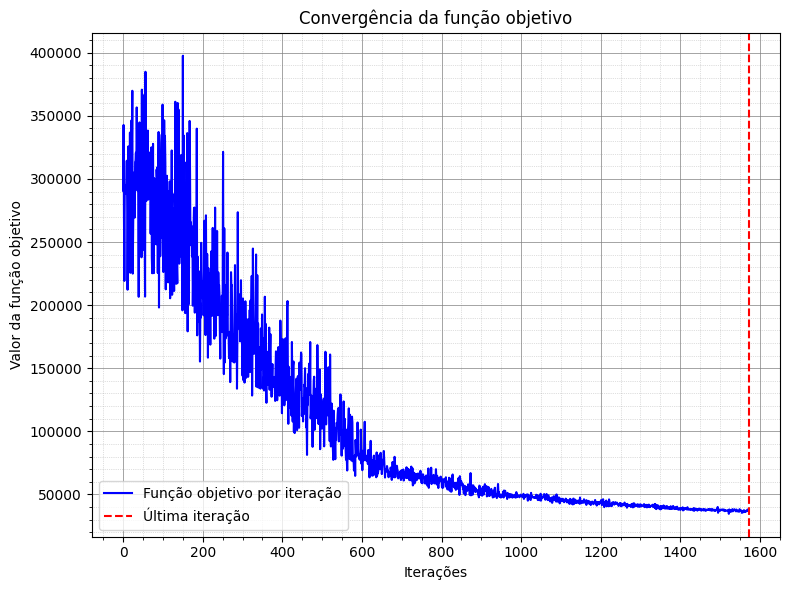

In [8]:
import numpy as np
import pickle
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Variáveis globais para armazenar os valores da função objetivo por iteração
objective_values = []

# Função para carregar o modelo sísmico
def load_seismic_model():
    with open('seismic_model.pkl', 'rb') as f:
        model = pickle.load(f)
    return model

# Função para carregar as velocidades estimadas 
def load_vs_estimated():
    with open('vs_estimated.pkl', 'rb') as f:
        vs_estimated_data = pickle.load(f)
    return vs_estimated_data['velocities'], vs_estimated_data['depths']

# Função para garantir que os arrays sejam interpolados para um comprimento uniforme
def standardize_length(arr, target_length):
    arr = np.array(arr)  # Certificar que 'arr' é um array NumPy
    if arr.size == target_length:
        return arr  # Já está no comprimento correto
    x_old = np.linspace(0, 1, arr.size)
    x_new = np.linspace(0, 1, target_length)
    return interp1d(x_old, arr, kind='linear', fill_value="extrapolate")(x_new)

# Função objetivo para a inversão usando DEAP
def inversion_objective(individual, estimated_vs, target_length=50):
    # Garantir que as velocidades (indivíduo) estejam interpoladas para o tamanho correto
    interpolated_vs = standardize_length(individual[:len(estimated_vs)], target_length)

    # Simula a curva de dispersão com base nas velocidades estimadas de Vs (indivíduo) para otimização
    simulated_dispersion = interpolated_vs  # O próprio indivíduo representa os valores simulados de Vs
    
    # Calcula o erro como a soma dos quadrados das diferenças entre a curva simulada e a curva estimada
    error = np.sum((simulated_dispersion - estimated_vs) ** 2)
    objective_values.append(error)  # Armazenar o valor da função objetivo
    return error,

# Configuração da DEAP para otimização evolutiva
def configure_deap(estimated_vs):
    if "FitnessMin" in creator.__dict__:
        del creator.FitnessMin
    if "Individual" in creator.__dict__:
        del creator.Individual

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 40, 240)  # Intervalo de velocidades S (Vs)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(estimated_vs))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", inversion_objective, estimated_vs=estimated_vs)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    return toolbox

# Função principal para rodar a inversão
def run_inversion():
    # Carregar as velocidades estimadas 
    estimated_vs, depths = load_vs_estimated()

    # Configurar DEAP
    toolbox = configure_deap(estimated_vs)

    # Realizar a evolução (inversão) usando algoritmo genético
    population = toolbox.population(n=50)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=True)

    # Extrair o melhor indivíduo após a evolução
    best_individual = tools.selBest(population, k=1)[0]

    # Salvar o melhor indivíduo (velocidades invertidas) no arquivo 'vs_inverted.pkl'
    with open('vs_inverted.pkl', 'wb') as f:
        pickle.dump({'velocities': best_individual, 'depths': depths}, f)

    # Plotar resultados
    plot_inverted_vs_profile(best_individual, depths)
    plot_convergence()

# Função para plotar o perfil invertido de Vs
def plot_inverted_vs_profile(velocities, depths):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.step(velocities, depths, where='post', color='b', linewidth=2, label=f'Modelo final após {len(objective_values)} iterações')
    ax.set_title('Perfil de velocidade Vs em função da profundidade (Evolutionary Algorithms)')
    ax.set_xlabel('Velocidade da onda S (m/s)')
    ax.set_ylabel('Profundidade (m)')
    ax.invert_yaxis()  # Inverter eixo Y para profundidade aumentar para baixo
    ax.grid(True)
    plt.tight_layout()
    ax.minorticks_on()
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

    plt.savefig('perfil_vs_invertido.png', dpi=300)
    plt.show()

# Função para plotar a convergência da função objetivo
def plot_convergence():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(objective_values, label='Função objetivo por iteração', color='blue')
    ax.set_title('Convergência da função objetivo')
    ax.set_xlabel('Iterações')
    ax.set_ylabel('Valor da função objetivo')
    ax.axvline(x=len(objective_values)-1, color='red', linestyle='--', label='Última iteração')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    ax.minorticks_on()
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

    plt.savefig('convergencia_funcao_objetivo.png', dpi=300)
    plt.show()

# Executar o processo de inversão
if __name__ == "__main__":
    run_inversion()


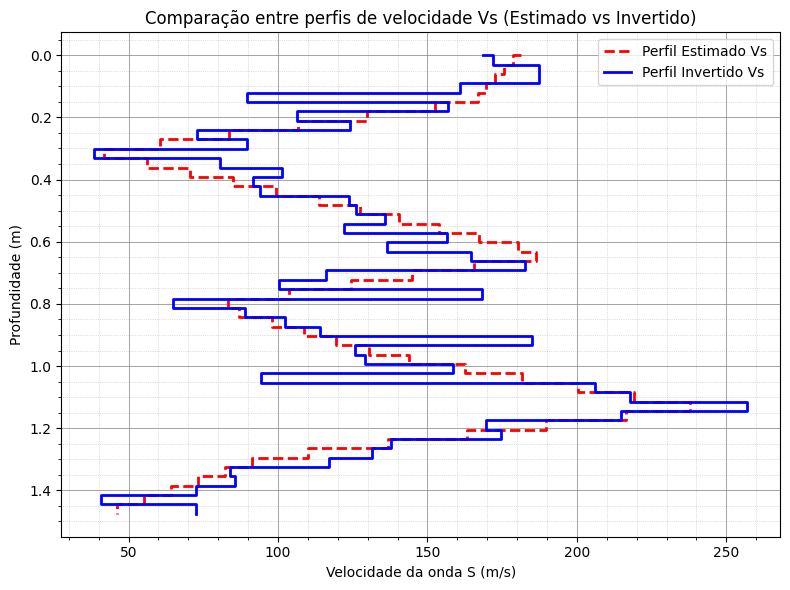

In [9]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Função para carregar o perfil estimado de Vs do script 1
def load_vs_estimated():
    with open('vs_estimated.pkl', 'rb') as f:
        vs_data = pickle.load(f)
    return vs_data['velocities'], vs_data['depths']

# Função para carregar o perfil invertido de Vs do script 2
def load_vs_inverted():
    with open('vs_inverted.pkl', 'rb') as f:
        vs_data = pickle.load(f)
    return vs_data['velocities'], vs_data['depths']

# Função para plotar a comparação dos perfis de velocidade
def plot_comparison():
    # Carregar os perfis de velocidade estimados e invertidos
    estimated_vs, estimated_depths = load_vs_estimated()
    inverted_vs, inverted_depths = load_vs_inverted()

    # Plotar ambos os perfis sobrepostos para comparação
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plotar o perfil estimado (do script 1)
    ax.step(estimated_vs, estimated_depths, where='post', label='Perfil Estimado Vs', color='red', linestyle='--', linewidth=2)
    
    # Plotar o perfil invertido (do script 2)
    ax.step(inverted_vs, inverted_depths, where='post', label='Perfil Invertido Vs', color='blue',  linewidth=2)
    
    # Configurações do gráfico
    ax.set_title('Comparação entre perfis de velocidade Vs (Estimado vs Invertido)')
    ax.set_xlabel('Velocidade da onda S (m/s)')
    ax.set_ylabel('Profundidade (m)')
    ax.invert_yaxis()  # Inverter eixo Y para profundidade aumentar para baixo
    ax.grid(True)
    ax.legend()

    # Ajustar o layout e exibir o gráfico
    plt.tight_layout()
    ax.minorticks_on()
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

    plt.savefig('comparacao_vs_estimated_vs_inverted.png', dpi=300)
    plt.show()

# Executar a função de plotar comparação
if __name__ == "__main__":
    plot_comparison()
